In [157]:
# Setup

!pip install pyro-ppl
!pip install scipy
!pip install matplotlib

     |████████████████████████████████| 12.4 MB 3.6 MB/s eta 0:00:01
  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
     |████████████████████████████████| 113 kB 22.2 MB/s eta 0:00:01


In [164]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
from pyro.distributions import Binomial, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma

import scipy
from matplotlib import pyplot

from collections import namedtuple

seed = 0

In [84]:
Samples = namedtuple("Samples", ["ctrls", "cases"])


In [38]:
# example of how to go from log_prob to prob
d = dist.Binomial(total_count=10,probs=.1)
torch.exp(d.log_prob(tensor(3.)))

tensor(0.0574)

In [45]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

Done
Scalar version took: 0.10182571411132812
Done
Tensor version took: 3.2070868015289307
Done
Tensor convert array version took: 0.13137578964233398


In [79]:
# Likelihood functions
# These assume univariate currently

# rr: relative risk
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - pD*pVgivenD) / (1 - pD)
    assert(p >= 0)
    return p
    
def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
# all values are torch tensors
# returns negative log likelihood for use as cost function
def likelihoodUnivariate(altCountsByGene, pD):
    nGenes = len(xCtrlAllGenes)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(pDgivenV, pi1):
        pi0 - 1 - pi
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # shap
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            
            if ctrlAltCount == 0 or caseAltCont == 0:
                next

            # likelihoodUnivariateSingleGene = function(xCtrl, xCase1, prevalence1, pi0, pi1, pDiseaseGivenVariant)
            ll = llUnivariateSingleGene(ctrlCount, caseCount, pD, pi0, pi1, pDgivenV)
            
            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlCount}, caseCount: {caseCount}")
                penaltyCount -= 1
                next
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        -logLikelihood * (nGenes / penaltyCount)

def cb(x, f, context):
    print("got callback", x, f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pD, nEpochs = 10):
    costFn = likelihoodUnivariate(altCountsByGene, pD)
    
    res = {"ll": [], "parameters": []}
    lls = res["ll"]
    params = res["parameters"]

    minLLDiff = 1
    minLLThresholdCount = 5
    thresholdHitCount = 0
    
    randomDist = Uniform(0, 1)
    fnArgs = [0, 0]
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    nGenes = len(altCountsByGene)
    pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
    # above .5 (for 2 hypothesis cas) we've flipped labels
    # TODO: update for multivariate
    nHypotheses = 2 #H0, H1
    pi1Bounds = ( 1/nGenes,  1/nHypotheses )
    bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        # pDgivenV
        fnArgs[0] = randomDist.sample()
        # pi1
        fnArgs[1] = randomDist.sample()
                
        try:
            fit = scipy.optimize.dual_annealing(costFn, bounds = bounds, x0 = fnArgs, callback = cb, seed = seed)
        except(e):
            print(f"Couldn't fit using: pi1guess: {pi1guess}, pDgivenVguess: {pDgivenVguess}")
            next
        
        print(fit)
#         if(is.null(fit) || fit$value == 0 || fit$convergence != 0 || fit$par[["pi1"]] <= 0 || fit$par[["pi1"]] >= 1 || fit$par[["pDiseaseGivenVariant"]] <= 0 || fit$par[["pDiseaseGivenVariant"]] >= 1 ) {
#           print("Failed to converge")
#           print(fit)
#           next
#         }

        if len(lls) == 0:
            lls.append(1)
            params.append(1)
            next
    
#         if(length(results$ll) == 0) {
#           results$ll = append(results$ll, fit$value)
#           results$par = append(results$par, data.frame(fit$par))
#           next
#         }
        
        maxPrevious = max(lls)
        
        if fit["value"] != maxPrevious and (fit["value"] - maxPrevious) > minLLDiff:
            thresholdHitCount = 0
            print(f"fit: {fit}")
            lls.append(fit["ll"])
            params.append(fit["params"])
            next
        
    
        #         if(fit$value != maxPrevious && (fit$value - maxPrevious) > minLLDiff) {
        #           thresholdHitCount = 0
        #           print(fit)
        #           results$ll = append(results$ll, fit$value)
        #           results$par = append(results$par, data.frame(fit$par))
        #           next
        #         }

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return res

In [101]:
nSamples.sum(1)

tensor([1.0100e+05, 1.0000e+03, 1.0000e+02])

In [96]:
rrMeans = tensor([10., 10., 5.])
rrShape = tensor(10.)
rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)

In [122]:
tensor(1.).expand([3,])

tensor([1., 1., 1.])

In [108]:
Binomial(total_count=nSamples[0].numpy, probs=[tensor(.1),tensor(.1)]).sample()

ValueError: Input arguments must all be instances of numbers.Number or torch.tensor.

In [153]:
def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    print("afs", afs, afs.shape)
    print("rrs", rrs, rrs.shape)
    for geneIdx in range(nGenes):
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx < nGenes * diseaseFractions[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
            geneProbs.append([probVgivenNotD, probVgivenD])
        
        # vectorzied is harder to follow but faster
#         altCounts = Binomial(total_count=nSamples, probs=tensor([probVgivenNotD, probVgivenD])).sample()
#         print("altCounts",altCounts)
        probs.append(geneProbs)
    probs = tensor(probs)

    altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
    print("altCounts", altCounts, altCounts.shape)
    
    return altCounts

In [154]:
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 1e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDs = tensor([.01, .01, .003])
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 5.])
afMean = tensor(1e-4)
afShape = tensor(10.)
print("nSamples shape",nSamples.shape)
print("nSamples shape expanded",nSamples.expand([20000, *nSamples.shape]))
pooledControls = True
altCountsByGene = genData(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)

nSamples shape torch.Size([3, 2])
nSamples shape expanded tensor([[[100000.,   1000.],
         [100000.,   1000.],
         [100000.,    100.]],

        [[100000.,   1000.],
         [100000.,   1000.],
         [100000.,    100.]],

        [[100000.,   1000.],
         [100000.,   1000.],
         [100000.,    100.]],

        ...,

        [[100000.,   1000.],
         [100000.,   1000.],
         [100000.,    100.]],

        [[100000.,   1000.],
         [100000.,   1000.],
         [100000.,    100.]],

        [[100000.,   1000.],
         [100000.,   1000.],
         [100000.,    100.]]])
TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0100, 0.0100, 0.0030])
afs tensor([5.6168e-05, 9.2838e-05, 1.0114e-04,  ..., 9.3016e-05, 1.2116e-04,
        1.5682e-04]) tor

In [156]:
altCountsByGene[:, 0:1, 0:1]

tensor([[[ 5.]],

        [[12.]],

        [[14.]],

        ...,

        [[ 5.]],

        [[14.]],

        [[11.]]])

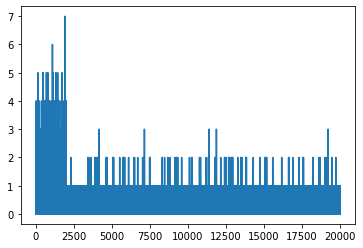

In [169]:
pyplot.plot(altCountsByGene[:, 1:2, 1:2].flatten())